In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-04-23 15:34:34.935484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745422475.169087      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745422475.235748      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Generating spectrogram images...
Spectrogram generation completed.
Found 3000 files belonging to 10 classes.


2025-04-23 15:42:36.977789: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.2625 - loss: 4.5677 - val_accuracy: 0.8667 - val_loss: 0.5026
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7911 - loss: 0.6209 - val_accuracy: 0.9433 - val_loss: 0.2162
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8753 - loss: 0.3833 - val_accuracy: 0.9550 - val_loss: 0.1627
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.9012 - loss: 0.2903 - val_accuracy: 0.9617 - val_loss: 0.1276
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9216 - loss: 0.2415 - val_accuracy: 0.9750 - val_loss: 0.0890
Converting full dataset to NumPy arrays...
Found 3000 files belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Active Learning Cycle 1
19/19 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
Validation Accuracy: 0.9417
Active Learning Cycle 2
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 639ms/step
Validation Accuracy: 0.9383
Active Learning Cycle 3
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 646ms/step
Validation Accuracy: 0.9500
Active Learning Cycle 4
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 600ms/step
Validation Accuracy: 0.9667
Active Learning Cycle 5
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 604ms/step
Validation Accuracy: 0.9733


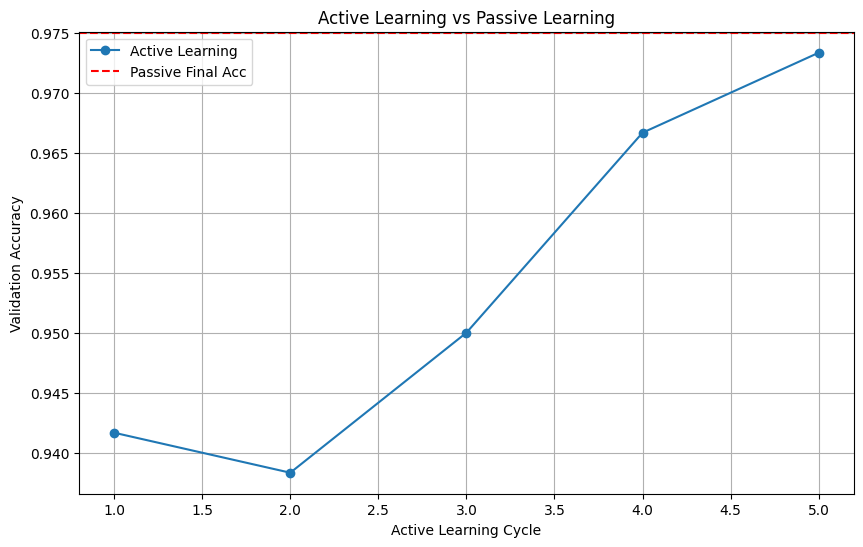

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import wave
import pylab
from pathlib import Path
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models
from IPython.display import display, Audio
import kagglehub

# ==== CONFIG ====
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
N_CLASSES = 10
OUTPUT_DIR = './audio_output'

# ==== DOWNLOAD DATA ====
free_spoken_digits_path = kagglehub.dataset_download('alanchn31/free-spoken-digits')
INPUT_DIR = os.path.join(free_spoken_digits_path, 'free-spoken-digit-dataset-master/recordings')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==== PREPROCESS WAV -> SPECTROGRAM PNG ====
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

spectrogram_dir = os.path.join(OUTPUT_DIR, 'audio-images')
if not os.path.exists(spectrogram_dir):
    os.makedirs(spectrogram_dir)
    print("Generating spectrogram images...")
    for filename in os.listdir(INPUT_DIR):
        if filename.endswith(".wav"):
            file_path = os.path.join(INPUT_DIR, filename)
            label = f'class_{filename[0]}'
            label_path = os.path.join(spectrogram_dir, label)
            os.makedirs(label_path, exist_ok=True)
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            save_path = os.path.join(label_path, Path(filename).stem + '.png')
            pylab.axis('off')
            pylab.savefig(save_path, bbox_inches='tight', pad_inches=0)
            pylab.close()
    print("Spectrogram generation completed.")

def add_audio_augmentation(model):
    model.add(tf.keras.layers.Lambda(
        lambda x: tf.keras.preprocessing.image.random_shift(x, 0.1, 0.1, row_axis=0, col_axis=1, channel_axis=2)
    ))
    return model

def preprocess_audio(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=TARGET_SR, duration=DURATION, res_type='kaiser_fast')
        return np.pad(audio, (0, MAX_LENGTH - len(audio)), 'constant') if len(audio) < MAX_LENGTH else audio
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return None

def extract_features(audio):
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=TARGET_SR, n_mels=N_MELS, hop_length=HOP_LENGTH
    )
    return librosa.power_to_db(mel_spec, ref=np.max)

def uncertainty_sampling(self, n_queries=20):
        probs = self.model.predict(self.X_pool, verbose=0)
        return np.argsort(np.max(probs, axis=1))[:n_queries]
    
def entropy_sampling(self, n_queries=20):
        probs = self.model.predict(self.X_pool, verbose=0)
        entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)
        return np.argsort(-entropy)[:n_queries]
def run_learning(self, X_test, y_test, cycles=5, 
                    query_strategy='entropy',
                    query_size=25,
                    epochs_per_cycle=8,
                    batch_size=32):
        
        initial_idx = self._balanced_initial_sample(100)
        X_train = self.X_pool[initial_idx]
        y_train = self.y_pool[initial_idx]
        
        # Remove selected samples from pool
        mask = np.ones(len(self.X_pool), dtype=bool)
        mask[initial_idx] = False
        self.X_pool = self.X_pool[mask]
        self.y_pool = self.y_pool[mask]
        
        acc_history = []
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        for cycle in range(cycles):
            print(f"\nCycle {cycle+1}/{cycles}")
            
            # Create new optimizer with schedule for each cycle
            self.model.optimizer = tf.keras.optimizers.Adam(
                learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                    0.001, decay_steps=100, decay_rate=0.96
                )
            )
            
            self.model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=epochs_per_cycle,
                batch_size=batch_size,
                callbacks=[early_stop],
                class_weight=self.class_weights,
                verbose=1
            )
            
            if query_strategy == 'uncertainty':
                query_idx = self.uncertainty_sampling(query_size)
            elif query_strategy == 'entropy':
                query_idx = self.entropy_sampling(query_size)
            else:
                query_idx = np.random.choice(len(self.X_pool), query_size, replace=False)
            
            # Update training set and pool
            X_train = np.concatenate([X_train, self.X_pool[query_idx]])
            y_train = np.concatenate([y_train, self.y_pool[query_idx]])
            
            mask = np.ones(len(self.X_pool), dtype=bool)
            mask[query_idx] = False
            self.X_pool = self.X_pool[mask]
            self.y_pool = self.y_pool[mask]
            
            loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
            acc_history.append(acc)
            print(f"Test Accuracy: {acc:.3f} | Samples used: {len(X_train)}")
        
        return acc_history





# ==== LOAD IMAGE DATASET ====
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    spectrogram_dir,
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb'
)

train_size = int(0.8 * len(full_dataset))
train_dataset = full_dataset.take(train_size)
valid_dataset = full_dataset.skip(train_size)

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
    resize = tf.keras.Sequential([layers.Rescaling(1./255)])
    if augment:
        resize.add(layers.RandomFlip("horizontal_and_vertical"))
        resize.add(layers.RandomRotation(0.2))
    ds = ds.map(lambda x, y: (resize(x), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset)

# ==== MODEL FUNCTION ====
def create_model():
    model = models.Sequential([
        layers.Input(shape=(*IMAGE_SIZE, 3)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ==== PASSIVE LEARNING ====
passive_model = create_model()
passive_history = passive_model.fit(train_dataset, validation_data=valid_dataset, epochs=5)
passive_model.save_weights("passive_weights.weights.h5")

# ==== CONVERT TO NUMPY ====
print("Converting full dataset to NumPy arrays...")
ds_np = tf.keras.preprocessing.image_dataset_from_directory(
    spectrogram_dir, image_size=IMAGE_SIZE, batch_size=1, shuffle=False
)

X_all, y_all = [], []
for images, labels in ds_np:
    X_all.append(images.numpy()[0])
    y_all.append(labels.numpy()[0])
X_all = np.array(X_all) / 255.0
y_all = np.array(y_all)

# ==== INITIAL LABELING ====
np.random.seed(42)
initial_indices = np.random.choice(len(X_all), 100, replace=False)
X_labeled = X_all[initial_indices]
y_labeled = y_all[initial_indices]

mask = np.ones(len(X_all), dtype=bool)
mask[initial_indices] = False
X_pool = X_all[mask]
y_pool = y_all[mask]

# ==== ACTIVE LEARNING ====
model = create_model()
model.load_weights("passive_weights.weights.h5")

val_images, val_labels = [], []
for x, y in valid_dataset.unbatch():
    val_images.append(x.numpy())
    val_labels.append(y.numpy())
val_images = np.array(val_images)
val_labels = np.array(val_labels)

active_accuracies = []
num_cycles = 5
samples_per_cycle = 50

for cycle in range(num_cycles):
    print(f"Active Learning Cycle {cycle + 1}")
    model.fit(X_labeled, y_labeled, epochs=3, batch_size=16, verbose=0)
    val_preds = model.predict(val_images)
    val_acc = accuracy_score(val_labels, np.argmax(val_preds, axis=1))
    active_accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.4f}")

    if len(X_pool) < samples_per_cycle:
        break
    subset_idx = np.random.choice(len(X_pool), 200, replace=False)
    probs = model.predict(X_pool[subset_idx], verbose=0)
    uncertainty = 1 - np.max(probs, axis=1)
    chosen = np.argsort(-uncertainty)[:samples_per_cycle]

    X_labeled = np.concatenate([X_labeled, X_pool[subset_idx][chosen]])
    y_labeled = np.concatenate([y_labeled, y_pool[subset_idx][chosen]])

    X_pool = np.delete(X_pool, subset_idx[chosen], axis=0)
    y_pool = np.delete(y_pool, subset_idx[chosen], axis=0)

# ==== PLOT COMPARISON ====
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_cycles + 1), active_accuracies, marker='o', label='Active Learning')
plt.axhline(y=passive_history.history['val_accuracy'][-1], color='r', linestyle='--', label='Passive Final Acc')
plt.xlabel('Active Learning Cycle')
plt.ylabel('Validation Accuracy')
plt.title('Active Learning vs Passive Learning')
plt.legend()
plt.grid(True)
plt.show()
